#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project3/'
# path = 'C:/Users/User/Desktop'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Input, concatenate
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
original_data = pd.read_csv(path + 'data01_train.csv')

#### 2) 기본 정보 조회

In [ ]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB


In [ ]:
original_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594,17.381568
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479,8.938316
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143,1.000000
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555,8.000000
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951,19.000000
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000,30.000000


In [ ]:
original_data.corr(numeric_only=True)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
tBodyAcc-mean()-X,1.000000,0.203297,-0.266383,0.012067,-0.018489,-0.040405,0.018367,-0.019752,-0.043303,0.048725,...,-0.012101,-0.011490,-0.567455,0.019251,0.034065,0.030968,-0.027010,0.028177,0.019025,0.027597
tBodyAcc-mean()-Y,0.203297,1.000000,-0.145709,-0.049467,-0.052489,-0.058499,-0.048703,-0.053018,-0.058559,-0.038544,...,-0.003101,-0.003467,0.076995,-0.013001,0.019670,0.074955,0.000039,0.002376,-0.022329,0.006299
tBodyAcc-mean()-Z,-0.266383,-0.145709,1.000000,-0.024839,-0.017613,-0.016924,-0.023323,-0.015794,-0.012575,-0.040397,...,0.018155,0.018234,0.056806,-0.036749,-0.054069,-0.035593,0.007045,-0.017900,-0.019169,-0.000459
tBodyAcc-std()-X,0.012067,-0.049467,-0.024839,1.000000,0.927809,0.851841,0.998656,0.921154,0.846308,0.981190,...,0.151555,0.116425,-0.043069,-0.032145,0.016542,-0.024749,-0.373500,0.470834,0.392843,-0.055562
tBodyAcc-std()-Y,-0.018489,-0.052489,-0.017613,0.927809,1.000000,0.893995,0.923386,0.997320,0.892843,0.916853,...,0.209119,0.177232,-0.027671,-0.022181,-0.012927,-0.015237,-0.380258,0.521249,0.429141,-0.107235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroJerkMean,gravityMean)",0.030968,0.074955,-0.035593,-0.024749,-0.015237,-0.004077,-0.025205,-0.013152,-0.004784,-0.028239,...,-0.018015,-0.015179,-0.027075,0.029856,-0.113677,1.000000,0.012598,0.005132,0.001242,0.010505
"angle(X,gravityMean)",-0.027010,0.000039,0.007045,-0.373500,-0.380258,-0.346237,-0.370024,-0.376665,-0.348279,-0.385300,...,-0.088810,-0.080113,0.012382,0.020700,-0.001992,0.012598,1.000000,-0.783107,-0.639201,0.012622
"angle(Y,gravityMean)",0.028177,0.002376,-0.017900,0.470834,0.521249,0.473572,0.466287,0.522401,0.474880,0.478832,...,0.092383,0.080726,-0.000955,-0.013508,-0.013863,0.005132,-0.783107,1.000000,0.590883,0.002219
"angle(Z,gravityMean)",0.019025,-0.022329,-0.019169,0.392843,0.429141,0.480593,0.389196,0.427486,0.477848,0.401217,...,0.056005,0.049690,-0.004422,-0.014844,-0.021702,0.001242,-0.639201,0.590883,1.000000,-0.085036


#### 3) 필요 함수 제작

In [ ]:
# 가장 기본적인 pipeline
def data01_pipeline(df):
  df.drop(columns='subject', inplace=True)

  scaler = MinMaxScaler()
  df = scaler.fit_transform(df)

  return df

# STANDING, SITTING, LAYING, WALKING, WALKING-UPSTAIRS, WALKING-DOWNSTAIRS
# LabelEncoder 방식으로 변환
def data01_pipeline_activity(df):
  x = df.drop(columns='Activity')
  y = df.loc[:, ['Activity']]

  df = data01_pipeline(x)

  lenc = LabelEncoder()
  y['Activity'] = lenc.fit_transform(y['Activity'])
  return df, y['Activity'], lenc.classes_

# Activity 기준으로 is_dynamic 변환
def data01_pipeline_is_dynamic(df):
  x = df.drop(columns='Activity')
  y = df.loc[:, ['Activity']]

  df = data01_pipeline(x)

  y['is_dynamic'] = y['Activity'].apply(lambda x : 1 if x in ('WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS') else 0)
  y.drop(columns=['Activity'], inplace=True)

  return df, y['is_dynamic']

# is_dynamic, Activity 전부 출력
def data01_pipeline_all(df):
  x = df.drop(columns='Activity')
  y = df.loc[:, ['Activity']]

  df = data01_pipeline(x)

  y['is_dynamic'] = y['Activity'].apply(lambda x : 1 if x in ('WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS') else 0)

  lenc = LabelEncoder()
  y['Activity'] = lenc.fit_transform(y['Activity'])
  return df, y['Activity'], lenc.classes_, y['is_dynamic']

# is_dynamic에 따라 분리를 위한 함수
def devide_is_dynamic(df, activity, is_dynamic):
  result = pd.concat([pd.DataFrame(df), activity, is_dynamic], axis=1)
  dynamic = result.loc[(is_dynamic == 1)]
  dynamic_x = dynamic.drop(columns=['Activity', 'is_dynamic'])
  dynamic_y = dynamic.loc[:, 'Activity']

  static = result.loc[(is_dynamic == 0)]
  static_x = static.drop(columns=['Activity', 'is_dynamic'])
  static_y = static.loc[:, 'Activity']


  return dynamic_x, dynamic_y, static_x, static_y

# Loop 테스트 함수
def loop_fit_test(param, x_train, y_train, x_val, y_val, loop_count=5, learning_rate=0.001, epochs=100, validation_split=0.2, es_info=None, verbose='auto'):
  result = []
  history_list = []
  model_list = []
  for i in range(loop_count):
    clear_session()
    model = Sequential(eval(param))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy')
    es = None if es_info is None else [EarlyStopping(monitor=es_info['monitor'], min_delta=es_info['min_delta'], patience=es_info['patience'])]
    history = model.fit(x_train, y_train, epochs=epochs, verbose=verbose, validation_split=validation_split, callbacks=es).history
    pred = model.predict(x_val)
    pred = pred.argmax(axis=1)
    result.append({
        'accuracy_score' : accuracy_score(y_val, pred),
        'confusion_matrix' : confusion_matrix(y_val, pred),
        'classification_report' : classification_report(y_val, pred)
    })
    history_list.append(history)
    model_list.append(model)
    print(f"{i+1} 번쨰 학습 Accuracy_score : {result[-1]['accuracy_score']}")
  return result, history_list, model_list

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [ ]:
# # Activity 전처리 파이프라인
# x1, y1, classes1 = data01_pipeline_activity(original_data.copy())
# # is_dynamic 전처리 파이프라인
# x2, y2 = data01_pipeline_is_dynamic(original_data.copy())

# Activity, is_dynamic 통합 전처리 파이프라인 함수
x, y_activity, classes, y_is_dynamic = data01_pipeline_all(original_data.copy())

# is_dynamic 기준으로 구분
# dynamic_x, dynamic_y, static_x, static_y = devide_is_dynamic(train, activity, is_dynamic)

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
# 전처리 함수로 처리 진행
# MinMax Scaler를 사용

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [ ]:
# 전처리 함수로 처리 진행
# LabelEncoder를 사용

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
# activity 분할
x_train, x_val, y_train, y_val = train_test_split(x, y_activity, test_size=0.3, random_state=20)

# is_dynamic 분할
x_train2, x_val2, y_train2, y_val2 = train_test_split(x, y_is_dynamic, test_size=0.3, random_state=20)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (0) 통계 데이터 변수 선언

In [ ]:
statistics_result = {}

### (1) 모델1

Base line 모델입니다. EarlyStopping을 곁들인

In [ ]:
param = '''[Input(shape=(x_train.shape[1],)),
        Dense(6, activation='softmax')]'''
es_info = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 5
}
result, history_list = loop_fit_test(param, x_train, y_train, x_val, y_val, loop_count=5, learning_rate=0.005, epochs=100, validation_split=0.2, es_info=es_info, verbose=0)
statistics_result['Model1'] = [result, history_list]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1 번쨰 학습 Accuracy_score : 0.9762039660056657
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2 번쨰 학습 Accuracy_score : 0.976770538243626
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3 번쨰 학습 Accuracy_score : 0.9762039660056657
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4 번쨰 학습 Accuracy_score : 0.973371104815864
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
5 번쨰 학습 Accuracy_score : 0.9716713881019831


In [ ]:
print(f"{len(result)}번 반복 평균 : {sum([x['accuracy_score'] for x in result]) / len(result)}")
print(result[-1]['confusion_matrix'])
print(result[-1]['classification_report'])

5번 반복 평균 : 0.974844192634561
[[312   0   0   0   0   0]
 [  0 316   7   0   0   0]
 [  0  37 284   0   0   0]
 [  0   0   0 290   1   1]
 [  0   0   0   1 253   0]
 [  0   0   0   0   3 260]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       0.90      0.98      0.93       323
           2       0.98      0.88      0.93       321
           3       1.00      0.99      0.99       292
           4       0.98      1.00      0.99       254
           5       1.00      0.99      0.99       263

    accuracy                           0.97      1765
   macro avg       0.97      0.97      0.97      1765
weighted avg       0.97      0.97      0.97      1765



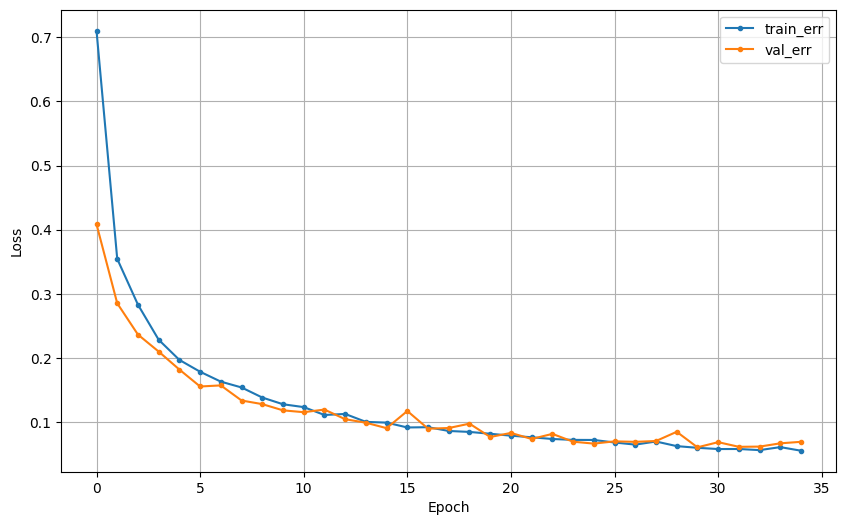

In [ ]:
dl_history_plot(history_list[-1])

### (2) 모델2

512 Node 히든레이어 5개, EarlyStopping을 곁들인

learning_rate = 0.005

Created by. 오병진

In [ ]:
param = '''[Input(shape=(x_train.shape[1],)),
            Dense(512, activation='relu'),
            Dense(512, activation='relu'),
            Dense(512, activation='relu'),
            Dense(512, activation='relu'),
            Dense(512, activation='relu'),
            Dense(6, activation='softmax')]'''
es_info = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 5
}
result, history_list = loop_fit_test(param, x_train, y_train, x_val, y_val, loop_count=5, learning_rate=0.005, epochs=100, validation_split=0.2, es_info=es_info, verbose=0)
statistics_result['Model2'] = [result, history_list]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1 번쨰 학습 Accuracy_score : 0.9365439093484419
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2 번쨰 학습 Accuracy_score : 0.9263456090651558
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3 번쨰 학습 Accuracy_score : 0.9592067988668556
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4 번쨰 학습 Accuracy_score : 0.9677053824362606
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5 번쨰 학습 Accuracy_score : 0.9677053824362606


In [ ]:
print(f"{len(result)}번 반복 평균 : {sum([x['accuracy_score'] for x in result]) / len(result)}")
print(result[-1]['confusion_matrix'])
print(result[-1]['classification_report'])

5번 반복 평균 : 0.9515014164305949
[[311   1   0   0   0   0]
 [  0 312  11   0   0   0]
 [  0  35 286   0   0   0]
 [  0   0   0 287   0   5]
 [  0   0   0   1 251   2]
 [  0   0   0   1   1 261]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       0.90      0.97      0.93       323
           2       0.96      0.89      0.93       321
           3       0.99      0.98      0.99       292
           4       1.00      0.99      0.99       254
           5       0.97      0.99      0.98       263

    accuracy                           0.97      1765
   macro avg       0.97      0.97      0.97      1765
weighted avg       0.97      0.97      0.97      1765



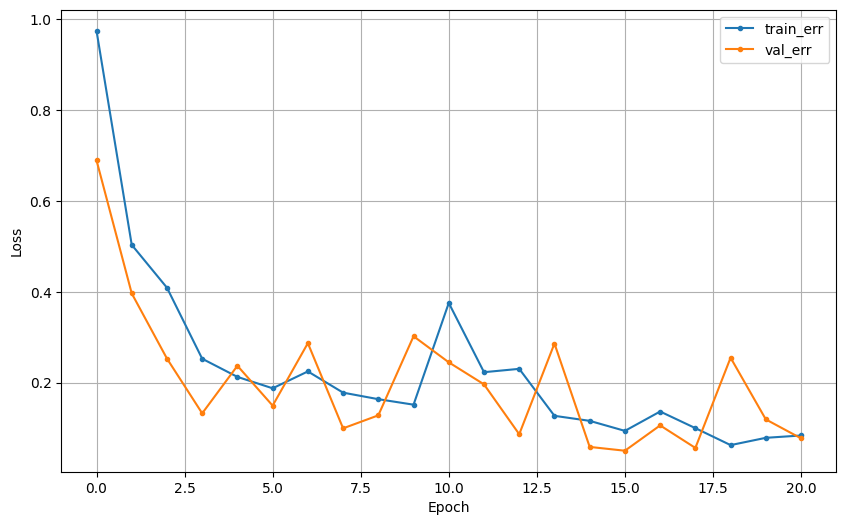

In [ ]:
dl_history_plot(history_list[-1])

### (3) 모델3

512, 256, 128, 64 히든 레이어

learning_rate = 0.001

Created by. 원대안

In [ ]:
param = '''[Input(shape = (x_train.shape[1],)),
          Dense(512, activation = 'relu'),
          Dense(256, activation = 'relu'),
          Dense(128, activation = 'relu'),
          Dense(64, activation = 'relu'),
          Dense(6, activation = 'softmax')]'''
es_info = None
result, history_list = loop_fit_test(param, x_train, y_train, x_val, y_val, loop_count=5, learning_rate=0.001, epochs=100, validation_split=0.2, es_info=es_info, verbose=0)
statistics_result['Model3'] = [result, history_list]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1 번쨰 학습 Accuracy_score : 0.9858356940509915
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2 번쨰 학습 Accuracy_score : 0.9790368271954675
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3 번쨰 학습 Accuracy_score : 0.9688385269121813
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4 번쨰 학습 Accuracy_score : 0.9858356940509915
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5 번쨰 학습 Accuracy_score : 0.9858356940509915


In [ ]:
print(f"{len(result)}번 반복 평균 : {sum([x['accuracy_score'] for x in result]) / len(result)}")
print(result[-1]['confusion_matrix'])
print(result[-1]['classification_report'])

5번 반복 평균 : 0.9810764872521247
[[312   0   0   0   0   0]
 [  0 314   9   0   0   0]
 [  0  13 308   0   0   0]
 [  0   0   0 291   0   1]
 [  0   0   0   0 254   0]
 [  0   0   0   1   1 261]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       0.96      0.97      0.97       323
           2       0.97      0.96      0.97       321
           3       1.00      1.00      1.00       292
           4       1.00      1.00      1.00       254
           5       1.00      0.99      0.99       263

    accuracy                           0.99      1765
   macro avg       0.99      0.99      0.99      1765
weighted avg       0.99      0.99      0.99      1765



In [ ]:
for i in result:
  print(i['confusion_matrix'])


[[312   0   0   0   0   0]
 [  1 307  15   0   0   0]
 [  0  14 307   0   0   0]
 [  0   0   0 289   1   2]
 [  0   0   0   1 251   2]
 [  0   0   0   0   3 260]]
[[312   0   0   0   0   0]
 [  1 294  28   0   0   0]
 [  0   9 312   0   0   0]
 [  0   0   0 291   0   1]
 [  0   0   0   2 250   2]
 [  0   0   0  10   2 251]]
[[311   1   0   0   0   0]
 [  0 297  26   0   0   0]
 [  0   8 313   0   0   0]
 [  0   0   0 288   0   4]
 [  0   0   0   3 250   1]
 [  0   0   0   1   3 259]]
[[312   0   0   0   0   0]
 [  3 306  14   0   0   0]
 [  0  22 297   1   0   1]
 [  0   0   0 289   0   3]
 [  0   0   0   0 248   6]
 [  0   0   0   1   1 261]]
[[312   0   0   0   0   0]
 [  1 302  20   0   0   0]
 [  0  10 311   0   0   0]
 [  0   0   0 289   1   2]
 [  0   0   0   1 252   1]
 [  0   0   0   2   2 259]]


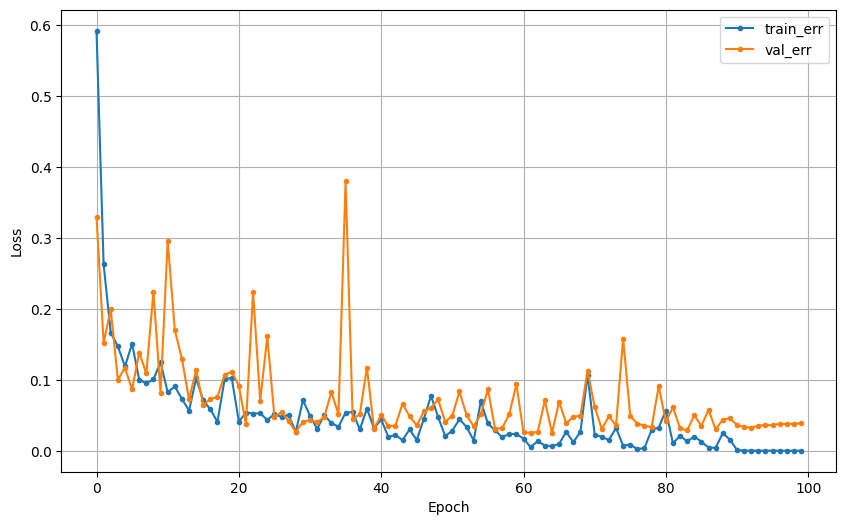

In [ ]:
dl_history_plot(history_list[-1])

### (4) 모델4

512, 512, 256, 128, 64, 32 히든레이어

2개의 Dropout으로 과적합 방지

learning_rate = 0.001

Created by. 소혜원

In [ ]:
param = '''[Input(shape=(x_train.shape[1],)),
        Dense(512, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(6, activation='softmax')]'''
es_info = None
result, history_list = loop_fit_test(param, x_train, y_train, x_val, y_val, loop_count=5, learning_rate=0.001, epochs=100, validation_split=0.2, es_info=es_info, verbose=0)
statistics_result['Model4'] = [result, history_list]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1 번쨰 학습 Accuracy_score : 0.9801699716713881
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
2 번쨰 학습 Accuracy_score : 0.9762039660056657
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
3 번쨰 학습 Accuracy_score : 0.9830028328611898
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4 번쨰 학습 Accuracy_score : 0.9835694050991501
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5 번쨰 학습 Accuracy_score : 0.969971671388102


In [ ]:
print(f"{len(result)}번 반복 평균 : {sum([x['accuracy_score'] for x in result]) / len(result)}")
print(result[-1]['confusion_matrix'])
print(result[-1]['classification_report'])

5번 반복 평균 : 0.9785835694050992
[[312   0   0   0   0   0]
 [  0 314   9   0   0   0]
 [  0  27 294   0   0   0]
 [  0   0   0 292   0   0]
 [  0   0   0  13 239   2]
 [  0   0   0   2   0 261]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       0.92      0.97      0.95       323
           2       0.97      0.92      0.94       321
           3       0.95      1.00      0.97       292
           4       1.00      0.94      0.97       254
           5       0.99      0.99      0.99       263

    accuracy                           0.97      1765
   macro avg       0.97      0.97      0.97      1765
weighted avg       0.97      0.97      0.97      1765



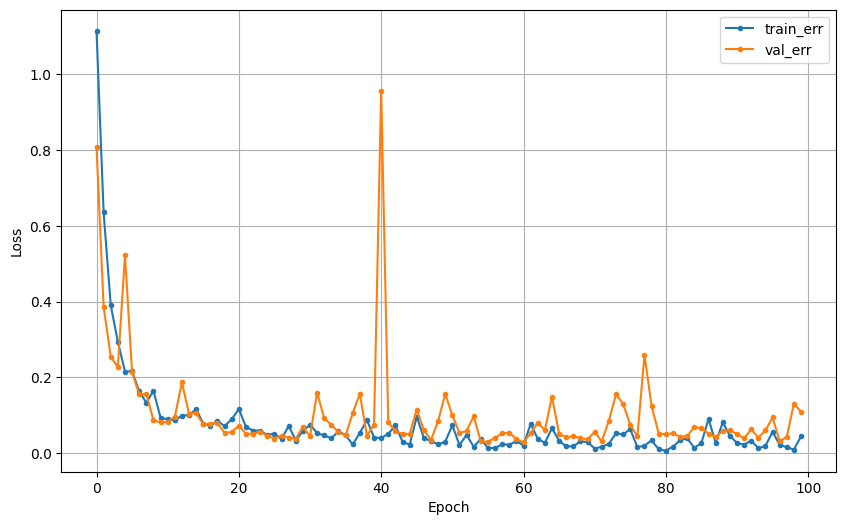

In [ ]:
dl_history_plot(history_list[-1])

### (5) 모델5

256, 256, 128, 64, 32 히든레이어

5개의 Dropout으로 과적합 방지

EarlyStopping 적용

learning_rate = 0.0001
epochs = 150

Created by. 서영민

In [ ]:
param = '''[Input(shape=(x_train.shape[1],)),
          Dense(256, activation='relu'),
          Dropout(0.2),
          Dense(256, activation='relu'),
          Dropout(0.2),
          Dense(128, activation='relu'),
          Dropout(0.2),
          Dense(64, activation='relu'),
          Dropout(0.2),
          Dense(32, activation='relu'),
          Dropout(0.2),
          Dense(6, activation='softmax')]'''
es_info = {
    'monitor': 'val_loss',
    'min_delta': 0.001,
    'patience': 20
}
result, history_list = loop_fit_test(param, x_train, y_train, x_val, y_val, loop_count=5, learning_rate=0.0001, epochs=150, validation_split=0.2, es_info=es_info, verbose=0)
statistics_result['Model5'] = [result, history_list]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1 번쨰 학습 Accuracy_score : 0.9813031161473088
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
2 번쨰 학습 Accuracy_score : 0.9818696883852691
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3 번쨰 학습 Accuracy_score : 0.9756373937677054
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4 번쨰 학습 Accuracy_score : 0.9711048158640226
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5 번쨰 학습 Accuracy_score : 0.9824362606232294


In [ ]:
print(f"{len(result)}번 반복 평균 : {sum([x['accuracy_score'] for x in result]) / len(result)}")
print(result[-1]['confusion_matrix'])
print(result[-1]['classification_report'])

5번 반복 평균 : 0.9784702549575071
[[312   0   0   0   0   0]
 [  0 310  13   0   0   0]
 [  0  13 308   0   0   0]
 [  0   0   0 289   1   2]
 [  0   0   0   0 253   1]
 [  0   0   0   0   1 262]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       0.96      0.96      0.96       323
           2       0.96      0.96      0.96       321
           3       1.00      0.99      0.99       292
           4       0.99      1.00      0.99       254
           5       0.99      1.00      0.99       263

    accuracy                           0.98      1765
   macro avg       0.98      0.98      0.98      1765
weighted avg       0.98      0.98      0.98      1765



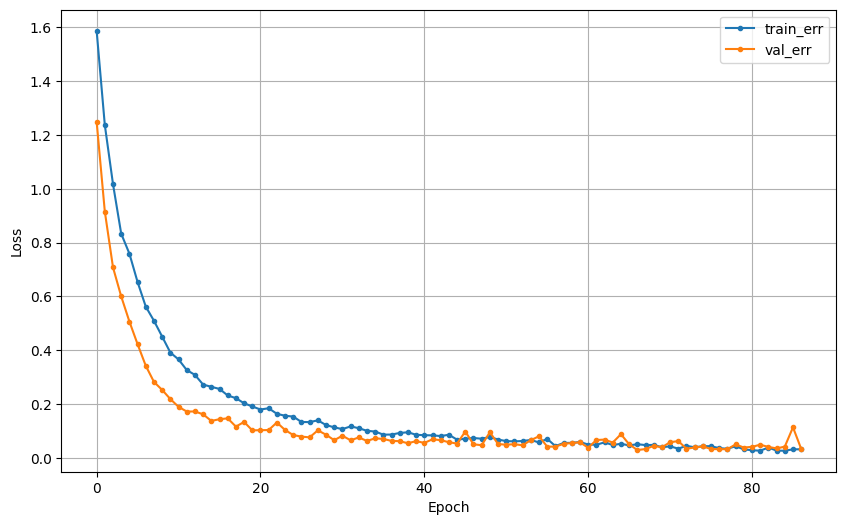

In [ ]:
dl_history_plot(history_list[-1])

### (6) 모델6

3개의 Input (Acc, Gyro, Angle) 으로 분할
> 각각 50, 50, 10 개의 히든 레이어로 연결

> concatenate로 히든레이어 병합

> 2개의 추가 히든레이어

learning_rate = 0.001
epochs = 100

Created by. 남다윤

In [ ]:
def func_dl_process(x_train, x_val, y_train, y_val):
  x_train = pd.DataFrame(x_train)
  x_val = pd.DataFrame(x_val)

  # 다중입력 모델링 (가속도, 각속도, angle센서(중력가속도와 각속도 등등의 벡터))
  # 'Acc'가 포함되면서 'angle'이 포함되지 않은 컬럼을 선택하여 x_train1에 저장
  x_train1 = x_train.filter(like='Acc').filter(regex='^(?!.*angle).*$', axis=1)
  x_val1 = x_val.filter(like='Acc').filter(regex='^(?!.*angle).*$', axis=1)

  # 'Gyro'가 포함되면서 'angle'이 포함되지 않은 컬럼을 선택하여 x_train2에 저장
  x_train2 = x_train.filter(like='Gyro').filter(regex='^(?!.*angle).*$', axis=1)
  x_val2 = x_val.filter(like='Gyro').filter(regex='^(?!.*angle).*$', axis=1)

  # 'angle' 컬럼  x_train3에 저장
  x_train3 = x_train.drop(columns=x_train1.columns).drop(columns=x_train2.columns)
  x_val3 = x_val.drop(columns=x_val1.columns).drop(columns=x_val2.columns)

  #입력
  input_1 = Input(shape=(x_train1.shape[1],),name='input_1')
  input_2 = Input(shape=(x_train2.shape[1],),name='input_2')
  input_3 = Input(shape=(x_train3.shape[1],),name='input_3')

  # 첫번째 입력을 위한 레이어
  hl1_1=Dense(50,activation='relu')(input_1)
  hl1_2=Dense(50,activation='relu')(input_2)
  hl1_3=Dense(10,activation='relu')(input_3)

  #세 히든레이어 결함
  cbl = concatenate([hl1_1,hl1_2,hl1_3])

  #추가 히든레이어
  hl2 = Dense(32,activation='relu')(cbl)
  hl3 = Dense(16,activation='relu')(hl2)

  #출력
  output = Dense(6,activation='softmax')(hl3)

  #모델 선언
  model = Model(inputs=[input_1,input_2,input_3],outputs = output)

  model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
  history = model.fit([x_train1, x_train2, x_train3], y_train, epochs=100, verbose=0, validation_split=0.2).history
  pred = model.predict([x_val1, x_val2, x_val3])
  pred = pred.argmax(axis=1)
  result = {
      'accuracy_score' : accuracy_score(y_val, pred),
      'confusion_matrix' : confusion_matrix(y_val, pred),
      'classification_report' : classification_report(y_val, pred)
  }
  return result, history

In [ ]:
result = []
history_list = []
for i in range(5):
  score, history = func_dl_process(x_train, x_val, y_train, y_val)
  result.append(score)
  history_list.append(history)
  print(f"{i+1} 번쨰 학습 Accuracy_score : {score['accuracy_score']}")
statistics_result['Model6'] = [result, history_list]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1 번쨰 학습 Accuracy_score : 0.9779036827195468
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
2 번쨰 학습 Accuracy_score : 0.9688385269121813
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
3 번쨰 학습 Accuracy_score : 0.973371104815864
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4 번쨰 학습 Accuracy_score : 0.9705382436260623
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5 번쨰 학습 Accuracy_score : 0.9773371104815864


In [ ]:
print(f"{len(result)}번 반복 평균 : {sum([x['accuracy_score'] for x in result]) / len(result)}")
print(result[-1]['confusion_matrix'])
print(result[-1]['classification_report'])

5번 반복 평균 : 0.9735977337110482
[[312   0   0   0   0   0]
 [  1 302  20   0   0   0]
 [  0  10 311   0   0   0]
 [  0   0   0 289   1   2]
 [  0   0   0   1 252   1]
 [  0   0   0   2   2 259]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       312
           1       0.97      0.93      0.95       323
           2       0.94      0.97      0.95       321
           3       0.99      0.99      0.99       292
           4       0.99      0.99      0.99       254
           5       0.99      0.98      0.99       263

    accuracy                           0.98      1765
   macro avg       0.98      0.98      0.98      1765
weighted avg       0.98      0.98      0.98      1765



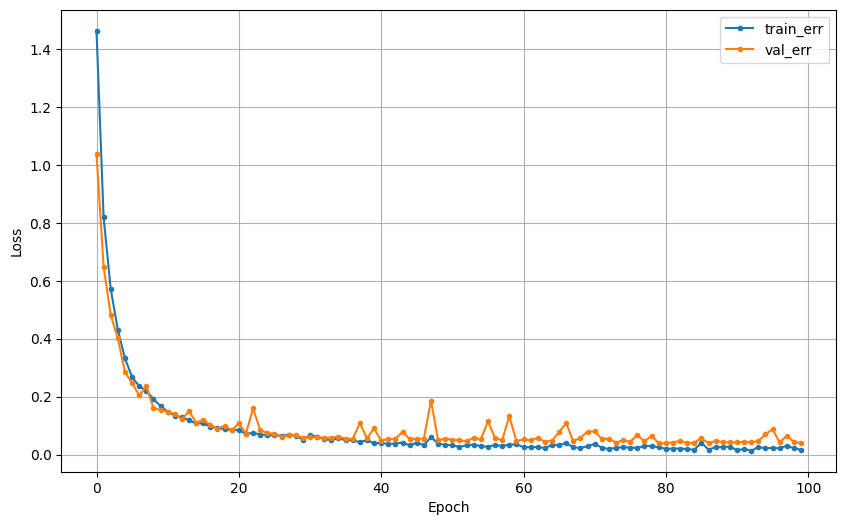

In [ ]:
dl_history_plot(history_list[-1])

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [ ]:
df_list = []

for name, statistics in statistics_result.items():
  t_dict = {'name': name}

  li = [x['accuracy_score'] for x in statistics[0]]
  # t_dict['mean'] = sum(li) / len(li)
  # t_dict['min'] = min(li)
  # t_dict['max'] = max(li)

  for idx, x in enumerate(statistics[0]):
    t_dict[f"{idx+1}"] = x['accuracy_score']

  df_list.append(t_dict)

df = pd.DataFrame(df_list)
df = df.set_index('name')
df.T.describe()

name,Model1,Model2,Model3,Model4,Model5,Model6
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.974844,0.951501,0.981076,0.978584,0.978470,0.973598
std,0.002216,0.018981,0.007448,0.005629,0.004939,0.004018
min,0.971671,0.926346,0.968839,0.969972,0.971105,0.968839
25%,0.973371,0.936544,0.979037,0.976204,0.975637,0.970538
50%,0.976204,0.959207,0.985836,0.980170,0.981303,0.973371
75%,0.976204,0.967705,0.985836,0.983003,0.981870,0.977337
max,0.976771,0.967705,0.985836,0.983569,0.982436,0.977904


# 테스트

In [ ]:
# 테스트 불러오기
data01_test = pd.read_csv('/content/drive/MyDrive/project/data01_test.csv')

In [ ]:
# test subject Drop
data01_test.drop(columns = 'subject', axis = 1 , inplace = True)
data01_test

In [ ]:
# x, y 분류
x = data01_test.drop(target, axis = 1)
y = data01_test.loc[:, target]

# MinMax Scaler
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

# integer encoding
y = y.map({'STANDING' : 0, 'LAYING': 1, 'WALKING':2, 'WALKING_DOWNSTAIRS' :3, 'WALKING_UPSTAIRS' : 4, 'SITTING':5})

x_train_test, x_test, y_train_test, y_val_test = train_test_split(x, y, test_size =.3, random_state = 1)


In [ ]:
# test Early Stopping
from keras.callbacks import EarlyStopping
# Early Stopping Setting
min_de = 0.001
pat = 20

es = EarlyStopping(monitor = 'val_loss', min_delta = min_de, patience = pat)

In [ ]:
# Set layer
clear_session()


model_test = Sequential([Input(shape=(x_train_test.shape[1],)),
          Dense(256, activation='relu'),
          Dropout(0.2),
          Dense(256, activation='relu'),
          Dropout(0.2),
          Dense(128, activation='relu'),
          Dropout(0.2),
          Dense(64, activation='relu'),
          Dropout(0.2),
          Dense(32, activation='relu'),
          Dropout(0.2),
          Dense(6, activation='softmax')])
model_test.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         143,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 253,094 (988.65 KB)

 Trainable params: 253,094 (988.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# model compile
model_test.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy')

# model fit
hist = model_test.fit(x_train_test, y_train_test, epochs = 150, validation_split = .2, callbacks = [es]).history

Epoch 1/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 1.7861 - val_loss: 1.6185
Epoch 2/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6533 - val_loss: 1.4918
Epoch 3/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.5649 - val_loss: 1.3722
Epoch 4/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4319 - val_loss: 1.2710
Epoch 5/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3686 - val_loss: 1.1765
Epoch 6/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2912 - val_loss: 1.0748
Epoch 7/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2192 - val_loss: 0.9583
Epoch 8/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1373 - val_loss: 0.8691
Epoch 9/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0605 - val_loss: 0.7850
Epoch 10/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9567 - val_loss: 0.7099
Epoch 11/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8837 - val_loss: 0.6450
Epoch 12/150
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

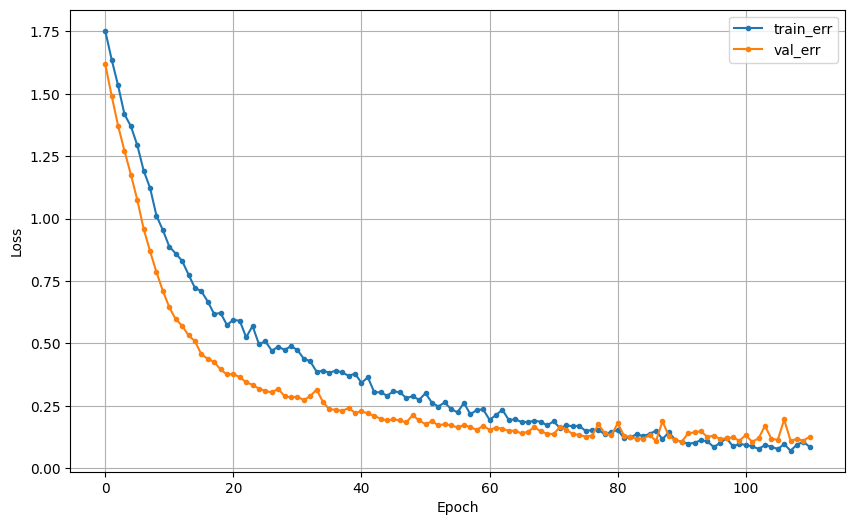

In [ ]:
dl_history_plot(hist)

In [ ]:
y_pred_test = model_test.predict(x_test)

y_pred_test=y_pred_test.argmax(axis = 1)
print(confusion_matrix(y_val_test , y_pred_test))
print(classification_report(y_val_test , y_pred_test))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[82  0  0  0  0  6]
 [ 0 79  0  0  0  0]
 [ 0  0 75  0  0  0]
 [ 0  0  3 60  1  0]
 [ 0  0  3  0 61  0]
 [ 8  0  0  0  0 64]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        88
           1       1.00      1.00      1.00        79
           2       0.93      1.00      0.96        75
           3       1.00      0.94      0.97        64
           4       0.98      0.95      0.97        64
           5       0.91      0.89      0.90        72

    accuracy                           0.95       442
   macro avg       0.96      0.95      0.95       442
weighted avg       0.95      0.95      0.95       442

